## 2: Preprocesado:  eliminación de columnas, imputación, estandarización y transformaciones

In [1]:
#!pip install scikit-optimize
#!pip install optuna
#!pip install pycaret
#from pycaret.classification import setup, compare_models, tune_model, evaluate_model
#from pycaret.classification import *
import pandas as pd                                             #Importar libreria pandas para leer archivo parquet
pd.set_option('display.float_format', '{:.2f}'.format)          #Formatro decimal para el display de los datos
from scipy.stats import skew, kurtosis, chi2_contingency          #Importar libreria scipy para calcular skew y kurtosis
import seaborn as sns                                           #Importar libreria seaborn para graficar
from sklearn.model_selection import train_test_split, RandomizedSearchCV            #Importar libreria sklearn para separar datos en train y test
from sklearn.dummy import DummyClassifier                       #Importar libreria sklearn para crear clasificador dummy
from sklearn.metrics import roc_auc_score, roc_curve, auc       #Importar libreria sklearn para calcular metricas de clasificacion binaria
import matplotlib.pyplot as plt                                 #Importar libreria matplotlib para graficar
import numpy as np                                              #Importar libreria numpy para calculos matematicos
from sklearn.pipeline import Pipeline                           #Importar libreria sklearn para crear pipelines
from sklearn.base import BaseEstimator, TransformerMixin        #La clase ColumnSelector hereda de BaseEstimator y TransformerMixin, lo que permite integrarse fácilmente en un pipeline de scikit-learn
from sklearn.impute import SimpleImputer                        #Importar libreria sklearn para imputar valores faltantes
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, MinMaxScaler, RobustScaler #Importar libreria sklearn para escalar y codificar variables
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression             #Importar libreria sklearn para crear modelo de regresion logistica
from sklearn.svm import SVC                                     #Importar libreria sklearn para crear modelo de SVM
from skopt import BayesSearchCV                                 #Importar libreria skopt para optimizar hiperparametros
from skopt.space import Real, Integer                           #Importar libreria skopt para definir espacio de busqueda de hiperparametros
import optuna                                                   #Importar libreria optuna para optimizar hiperparametros
from sklearn.ensemble import RandomForestClassifier             #Importar libreria sklearn para crear modelo de Random Forest
from sklearn.model_selection import train_test_split            #
from sklearn.ensemble import RandomForestClassifier             #
from sklearn.neural_network import MLPClassifier                #Importar libreria sklearn para crear modelo de redes neuronales

In [2]:
#Vista general del conjunnto de datos de entrenamiento
train_dataset = pd.read_parquet ("df_train.parquet")
data_df = pd.read_parquet ("df_train.parquet")

In [3]:
#Split X, y de los datos
X, y = train_dataset.drop(columns="Target"), train_dataset["Target"] #Partimos el dataset de entrenamiento en X y y

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=42)

Observación: Se ha decidido utilizar el 10% de los datos de entrenamiento para realizar la validaciones, ya que el dataset es muy grande y el tiempo de ejecución es muy alto.

### 2.1  Eliminación de columnas

Despues de validar las celdas anteriores, considerando el juicio experto de un experto en medicina y por temas de rendimiento y tiempo se dedicen dejar las siguientes variables

In [5]:
# Clase para seleccionar columnas a conservar
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.columns]  # Selecciona solo las columnas especificadas

# Columnas a conservar

#columns_to_keep =['AGRUPACION_DIASTOLICA','AGRUPACION_SISTOLICA','CANCER_MAMA_FAMILIAR','CANCER_OTRO_SITIO','CANCER_OTRO_SITIO_FAMILIAR','Cant_Fliar_CP','Cant_Fliar_riesgos','Cant_gr_flia','Cant_riesgos_flia_mean','cantidad_serv_flia','CANTIDAD_SERVICIOS','CEREBRAL','CEREBRAL_FAMILIAR','conteo_dx_diferentes','CORONARIOS','CORONARIOS_FAMILIAR','DIABETES','DIABETES_FAMILIAR','EDAD','ENFERMEDAD_RENAL','ENFERMEDAD_RENAL_FAMILIAR','ESTADO_CIVI','estrato','HIPERTENSION','HIPERTENSION_FAMILIAR','IMC','Intercepto','Intercepto_flia','MEDICAMENTOS','MEDICINA ESPECIALIZADA','MEDICINA GENERAL','OTROS_ANTECEDENTES_VASCULARES','parentesco','Pendiente','Pendiente_flia','PROGRAMA','Promedio_costo','Promedio_costo_flia','RIESGOS','TIEMPO_AFILIACION','TIEMPO_ULTIMA_CITA']

columns_to_keep = ['EDAD', 'AGRUPACION_DIASTOLICA', 'CANCER_OTRO_SITIO',
                   'CANCER_OTRO_SITIO_FAMILIAR', 'DIABETES',
                   'DIABETES_FAMILIAR', 'HIPERTENSION',
                   'HIPERTENSION_FAMILIAR']  # Especifica tus columnas a conservar

#columns_to_keep = ['EDAD', 'AGRUPACION_DIASTOLICA', 'CANCER_OTRO_SITIO',
#                    'DIABETES', 'HIPERTENSION',
#                   ]  # Especifica tus columnas a conservar





### 2.2  Listado de columnas numéricas y categorícas

In [6]:
# Función para identificar columnas numéricas y categóricas
def identify_columns(df, columns_to_keep):
    df_filtered = df[columns_to_keep]  # Filtrar columnas
    numerical = df_filtered.select_dtypes(include=np.number).columns.tolist()  # Obtener numéricas
    categorical = df_filtered.select_dtypes(exclude=np.number).columns.tolist()  # Obtener categóricas
    return numerical, categorical

# Obtener columnas numéricas y categóricas
numerical_columns, categorical_columns = identify_columns(X_train, columns_to_keep)

# Verifica que se obtengan correctamente
print("Columnas numéricas:", numerical_columns)
print("Columnas categóricas:", categorical_columns)

Columnas numéricas: ['EDAD']
Columnas categóricas: ['AGRUPACION_DIASTOLICA', 'CANCER_OTRO_SITIO', 'CANCER_OTRO_SITIO_FAMILIAR', 'DIABETES', 'DIABETES_FAMILIAR', 'HIPERTENSION', 'HIPERTENSION_FAMILIAR']


### 2.3  Pipeline para imputar y codificar variable categóricas

In [7]:
# Clase personalizada para corregir el valor "2" por la moda
class ReplaceWithMode(BaseEstimator, TransformerMixin):
    def __init__(self, incorrect_value=2, columns=None):
        self.incorrect_value = incorrect_value
        self.columns = columns
        self.modes_ = {}

    def fit(self, X, y=None):
        # Calcular la moda para cada columna especificada
        for col in self.columns:
            self.modes_[col] = X[col].mode()[0]
        return self

    def transform(self, X):
        X_copy = X.copy()
        for col in self.columns:
            # Reemplazar el valor incorrecto por la moda en las columnas especificadas
            X_copy[col] = X_copy[col].replace(self.incorrect_value, self.modes_[col])
        return X_copy

In [8]:
# Pipeline para imputar y codificar variables categóricas
categorical_pipeline = Pipeline([
    ("replace_with_mode", ReplaceWithMode(incorrect_value=2, columns=categorical_columns)),  # Reemplazar el valor 2 por la moda
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(drop='first', handle_unknown='ignore'))
])

### 2.4  Pipeline para imputar y estandarizar variables numéricas

In [9]:
# Pipeline para imputar variables numéricas
numerical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

### 2.5  Ajustar pipeline

In [10]:
# Pipeline completo que combina todo
preprocessing_pipeline = Pipeline(steps=[
    ('column_selector', ColumnSelector(columns_to_keep)),  # Seleccionar columnas a conservar
    ('preprocessor', ColumnTransformer([
        ("numerical", numerical_pipeline, numerical_columns),  # Aplicar pipeline numérico
        ("categorical", categorical_pipeline, categorical_columns)  # Aplicar pipeline categórico
    ], remainder='drop'))  # Eliminar columnas no especificadas
])

In [11]:
preprocessing_pipeline

Pipeline(steps=[('column_selector',
                 ColumnSelector(columns=['EDAD', 'AGRUPACION_DIASTOLICA',
                                         'CANCER_OTRO_SITIO',
                                         'CANCER_OTRO_SITIO_FAMILIAR',
                                         'DIABETES', 'DIABETES_FAMILIAR',
                                         'HIPERTENSION',
                                         'HIPERTENSION_FAMILIAR'])),
                ('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['E...
                                                                                            'CANCER_OTRO_SITIO_FAMILIAR',
                                                                                            'DIABETES',
                                                                                            'DIABETES_FAMILIAR',
                                                                                            'HIPERTENSION',
                                                                                            'HIPERTENSION_FAMILIAR'])),
                                                                  ('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['AGRUPACION_DIASTOLICA',
                                                   'CANCER_OTRO_SITIO',
                                                   'CANCER_OTRO_SITIO_FAMILIAR',
                                                   'DIABETES',
                                                   'DIABETES_FAMILIAR',
                                                   'HIPERTENSION',
                                                   'HIPERTENSION_FAMILIAR'])]))])

In [12]:
# Aplicar el pipeline al conjunto de datos
X_train_transformed = preprocessing_pipeline.fit_transform(X_train)
X_test_transformed = preprocessing_pipeline.transform(X_test)
print(X_train_transformed.shape)
print(X_test_transformed.shape)

(2349, 16)
(21145, 16)


### 2.6  Validación del preprocesado con regresión logística

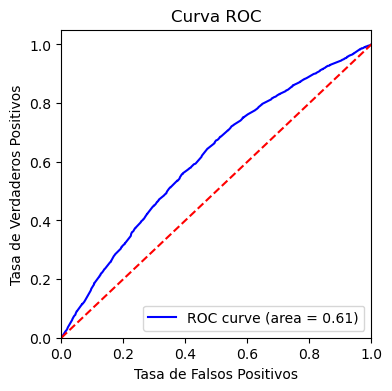

In [13]:
model = LogisticRegression()
model.fit(X_train_transformed, y_train)
# Predecir las probabilidades para la curva ROC
y_pred_proba = model.predict_proba(X_test_transformed)[:, 1]
# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
# Graficar la curva ROC
plt.figure(figsize=(4, 4))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Línea de referencia
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')

### 2.7  SVC - Modelo de clasificación No. 1

A continuación se buscarán los mejores hiperparámetros para el modelo SVC:

In [14]:
def objective(trial):
    # Definición de los hiperparámetros a optimizar
    C = trial.suggest_loguniform('C', 1, 10)  # Regularización
    kernel = trial.suggest_categorical('kernel', ['rbf', 'poly', 'linear'])  # Incluye el kernel lineal
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto', 0.1, 1.0, 10.0, 100])  # Valores para gamma

    # Hiperparámetros adicionales para el kernel polinómico
    degree = trial.suggest_int('degree', 2, 10) if kernel == 'poly' else 0
    coef0 = trial.suggest_float('coef0', 0.0, 1.0) if kernel == 'poly' else 0.0
    class_weight = trial.suggest_categorical('class_weight', [None, 'balanced'])
    tol = trial.suggest_float('tol', 1e-5, 1e-1, log=True)
    max_iter = trial.suggest_int('max_iter', 100, 1000)

    # Crear el clasificador SVC con los hiperparámetros sugeridos
    svc = SVC(C=C, kernel=kernel, gamma=gamma, degree=degree, coef0=coef0,
              class_weight=class_weight, tol=tol, max_iter=max_iter,
              probability=True, random_state=42)

    # Ajustar el modelo
    svc.fit(X_train_transformed, y_train)

    # Predecir en el conjunto de validación
    y_pred_prob_svc = svc.predict_proba(X_test_transformed)[:, 1]

    # Calcular el ROC AUC
    roc_auc = roc_auc_score(y_test, y_pred_prob_svc)

    return roc_auc

# Crear un estudio para la optimización
study = optuna.create_study(direction='maximize')

# Ejecutar la optimización
study.optimize(objective, n_trials=100)

# Imprimir los mejores hiperparámetros
print("Best hyperparameters:", study.best_params)
print("Best ROC AUC:", study.best_value)

[I 2024-10-02 20:32:28,645] A new study created in memory with name: no-name-639863e4-cbfc-4f8c-a697-59777b8b7934
C:\Users\ACER\AppData\Local\Temp\ipykernel_14532\1788003959.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1, 10)  # Regularización
C:\Users\ACER\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=514).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
[I 2024-10-02 20:32:29,259] Trial 0 finished with value: 0.535900728993276 and parameters: {'C': 3.3357909631992486, 'kernel': 'linear', 'gamma': 100, 'class_weight': 'balanced', 'tol': 8.13990820154597e-05, 'max_iter': 514}. Best is trial 0 with value: 0.535900728993276.
C:\Users\ACER\AppData\Local\Temp\ipykernel_14

Best hyperparameters: {'C': 4.885890936592065, 'kernel': 'linear', 'gamma': 'scale', 'class_weight': None, 'tol': 0.06684252348474977, 'max_iter': 460}
Best ROC AUC: 0.6138572691857133


C:\Users\ACER\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=460).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


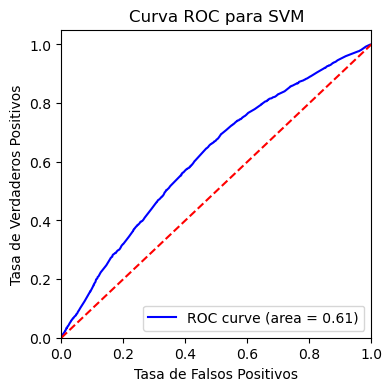

In [17]:
#Ajustamos el modelo con los mejores hiperparámetros:
C = 4.885890936592065
kernel = 'linear'
gamma = 'scale'
class_weight = None
tol = 0.06684252348474977
max_iter = 460
degree = 0
coef0 = 0

# Crear el clasificador SVC con los hiperparámetros sugeridos
svc = SVC(C=C, kernel=kernel, gamma=gamma, degree=degree, coef0=coef0,
          class_weight=class_weight, tol=tol, max_iter=max_iter,
          probability=True, random_state=42)

# Ajustar el modelo
svc.fit(X_train_transformed, y_train)

# Predecir en el conjunto de validación
y_pred_prob_svc = svc.predict_proba(X_test_transformed)[:, 1]

# Calcular el ROC AUC
roc_auc = roc_auc_score(y_test, y_pred_prob_svc)

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_svc)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure(figsize=(4, 4))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Línea de referencia
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC para SVM')
plt.legend(loc='lower right')
plt.show()


Encontramos un ROC de 0.61 para esta configuración de nuestro modelo